# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import sklearn.decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import rc
import os
import pretty_table as pretty
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
array = []
i = 0
with open('/Users/dangeles/Downloads/cel235_bed_file_ucsc.txt', 'r') as f:
    for line in f:
        a = f.readline().split('\t')
        if a[0] != '':
            try:
                array.append([a[0], a[3]])
            except:
                print(a)
                print('uh oh')

name_dict = {}
with open('/Users/dangeles/Downloads/cel235_ensembl_to_gene_name', 'r') as f:
    for line in f:
        a = f.readline().strip().split('\t')
        name_dict[a[0]] = a[1]

In [3]:
chrom = pd.DataFrame(array, columns=['chr', 'target_id'])

In [2]:
ensembl = pd.read_csv('/Users/dangeles/Downloads/cel235_ensembl_to_gene_name', 
                      sep='\t')
ensembl.columns = ['target_id', 'ens_gene']

FileNotFoundError: File b'/Users/dangeles/Downloads/cel235_ensembl_to_gene_name' does not exist

In [5]:
tidy  = pd.read_csv('../output/dpy_22_results.csv')

In [6]:
chrom['ext_gene'] = chrom.target_id.map(name_dict)

chrom = chrom[chrom.target_id.isin(tidy.target_id)]
tidy = tidy[tidy.target_id.isin(chrom.target_id)]

q = 0.1

In [7]:
tidy = tidy[tidy['phenotypic class'] != 'bx93 specific']
chrom = chrom[chrom.chr != 'chrM']

In [13]:
bonferroni = chrom.chr.nunique()*tidy['phenotypic class'].nunique()
pval = 10**-2
alpha = pval/bonferroni

m = 'pval required for stat. sig. after bonferroni correction: {0:.2g}'
print(m.format(alpha))

n_total = len(chrom)
array = []
for name, chrom_group in chrom.groupby('chr'):
    for name2, phenotype in tidy.groupby('phenotypic class'):
        # total genes in this chromosome
        n_chrom = len(chrom_group)

        # DEGs in this chromosome in this genotype
        degs_in_chrom = chrom_group.target_id.isin(phenotype.target_id)
        n_found = chrom_group[degs_in_chrom].target_id.nunique()
        
        n_expected = stats.hypergeom.mean(n_total, n_chrom,
                                          phenotype.ens_gene.nunique())
        
        # p-value calculation:
        if n_found/n_expected < 1:
            pval = stats.hypergeom.cdf(n_found, n_total, n_chrom,
                                       phenotype.ens_gene.nunique())
        else:
            pval = stats.hypergeom.sf(n_found, n_total, n_chrom,
                                      phenotype.ens_gene.nunique())

        if pval < alpha:
            l = [name, name2, n_found,
                 '{0:.2g}'.format(n_found/n_expected),
                 '{0:.1g}'.format(pval)
                ]
            pretty.table_print(l, space=15)
        array.append([name, name2, n_found/n_expected, pval])

df = pd.DataFrame(array, columns=['chr', 'phenotype', 'fold change', 'pval'])

pval required for stat. sig. after bonferroni correction: 0.00033
chrV                bx93 associated     60                  1.7                 1e-05               
chrV                sy622 associated    109                 1.6                 2e-08               
chrX                bx93 associated     43                  1.7                 0.0002              
chrX                sy622 specific      170                 1.4                 5e-06               
chrX                transhet specific   47                  0.55                9e-07               


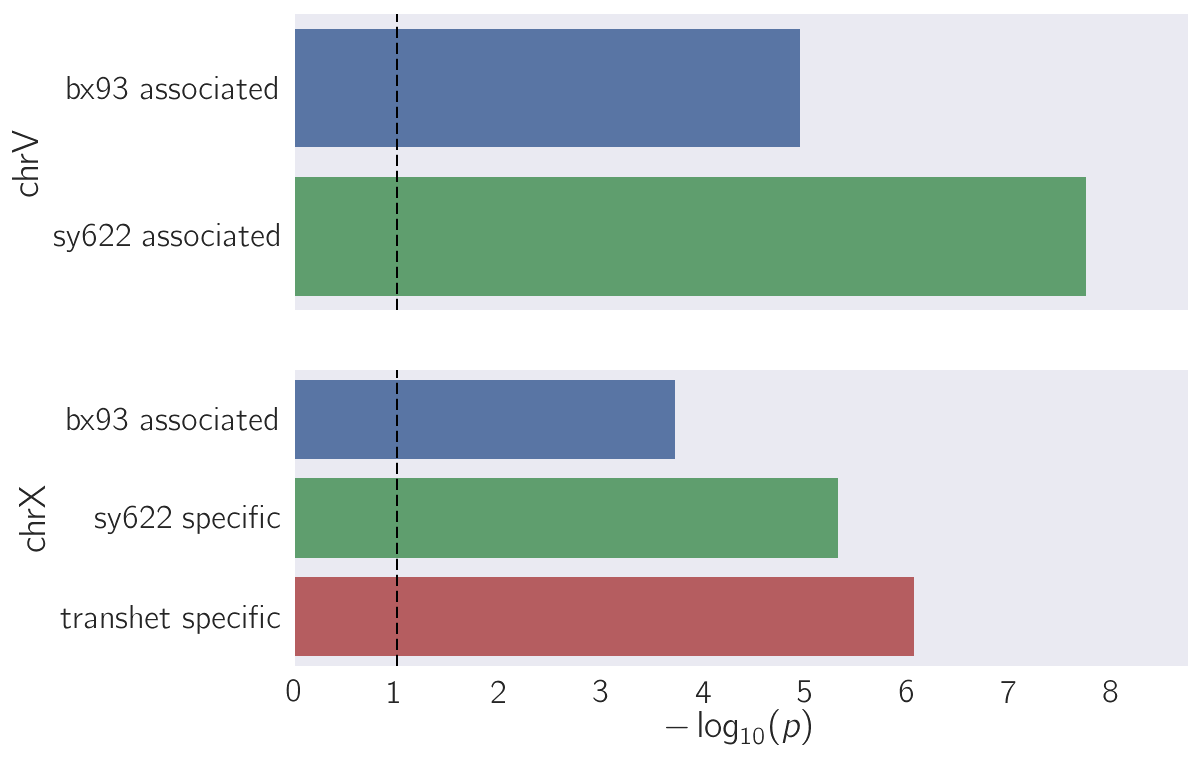

In [18]:
fig, ax =  plt.subplots(len(df[df.pval < alpha].chr.unique()), 1, figsize=(8, 6), sharex=True)

max_p = -df.pval.apply(np.log10).min()
i = 0
for name, group in df[df.pval < alpha].groupby('chr'):
    axi = ax[i]
    sns.barplot(-group.pval.apply(np.log10).values, group.phenotype.values, ax=axi)
    axi.set_ylabel(name)
    axi.axvline(1, lw=1, ls='--', color='black')
    axi.set_xlim(0, max_p + 1)
    i += 1

plt.xlabel('$-\log_{10}(p)$')

plt.savefig('../output/chromosomal_representation.pdf', bbox_inches='tight')